In [1]:
import os
import random
import re
import time

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.metrics import SCORERS, classification_report, confusion_matrix, f1_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer, TfidfVectorizer #, HashingVectorizer
from sklearn.pipeline import Pipeline

from sklearn.svm import LinearSVC, SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors.nearest_centroid import NearestCentroid
from sklearn.naive_bayes import MultinomialNB, GaussianNB
#from sklearn.linear_model import SGDlassifier(loss = ...) # loss='hinge'/'log'

from sklearn.model_selection import GridSearchCV

from joblib import dump, load

# Summary

### Bag od words with SVMs, Log-Regression, Random-Forest etc. on top 

* Build and test a preprocessing pipe:
    * Handle *LaTeX* formulas before count-vectorizatation and TFIDF transformation.
    * Test a handful of preprocessing parameters (inc. 2-grams, idf switched on/off, maximal document frequency) with a single untuned classifier.
* Test a handful of shallow multiclass classifiers with *macro-F1* as the objective, this time without broadly changing the preprocessing parameters:
* The grid-search in both step is (likely) performed on a fraction of the train data.
* Fit the tuned classifiers to the whole of train data.
* Collect the *macro-f1* scores obtained on the test data.
* ... Save the best fitted model to file

---

## Choose the volume
The whole forthcoming analysis in the notebook is parametrized by the number of records that we wish to use. The maximum that we have is 838_804 in *data/bare_all.csv*, but we will choose to work with a smaller sample for convenience. This is done conceptually before any considerations about testing, validating etc., as if we simply had harvested a smaller dataset. Also, we will first tune the classifiers on a *small_number* of records, and only later refit and evaluate them on a *big_number* of records as if we had harvested additional data after the tuning (see below). 

In [2]:
small_number = 200_000
big_number = 700_000
total = 838_804

## Define the measure of success

In [6]:
# available scikit-learn's scorers
SCORERS.keys()

dict_keys(['explained_variance', 'r2', 'neg_median_absolute_error', 'neg_mean_absolute_error', 'neg_mean_squared_error', 'neg_mean_squared_log_error', 'accuracy', 'roc_auc', 'balanced_accuracy', 'average_precision', 'neg_log_loss', 'brier_score_loss', 'adjusted_rand_score', 'homogeneity_score', 'completeness_score', 'v_measure_score', 'mutual_info_score', 'adjusted_mutual_info_score', 'normalized_mutual_info_score', 'fowlkes_mallows_score', 'precision', 'precision_macro', 'precision_micro', 'precision_samples', 'precision_weighted', 'recall', 'recall_macro', 'recall_micro', 'recall_samples', 'recall_weighted', 'f1', 'f1_macro', 'f1_micro', 'f1_samples', 'f1_weighted'])

In [3]:
# my choice
scoring = "f1_macro"
average = "macro"

---

## Read in the two-column data frame (text + labels)

In [4]:
file = os.path.join("data", "bare_all.csv")
data = pd.read_csv(file, delimiter='\t', nrows=small_number)

# it happens to be shuffled already
data_train = data[: int(small_number*0.8)]
data_test = data[int(small_number*0.8) :]

text_train = data_train.text
label_train = data_train.label

## Have a look at the data

In [9]:
print(f"No. all records in memory: {len(data)}")
with pd.option_context('display.max_colwidth', 120):
    display(data_train[:3])

No. all records in memory: 200000


,text,label
0,On the interplay between star formation and feedback in galaxy formation simulations. We investigate the star forma...,phys
1,Transversal Homotopy Monoids of Complex Projective Space. We will give a geometric description of the nth transvers...,math
2,Remarks on some typical assumptions in dynamo theory. Some concepts used in the theory of convection-driven dynamos...,phys


Abstracts of scientific papers tend to be written in a formal style, to not contain typos, nor direct citations, little references, ...

In [10]:
for _ in range(2):
    print(text_train.iloc[random.choice(range(len(text_train)))])
    print("---")

Thermo-magnonic diode: rectification of energy and magnetization currents.  We investigate the dynamics of two coupled macrospins connected to thermal baths at different temperatures. The system behaves like a diode which allows the propagation of energy and mag- netization currents in one direction only. This effect is described by a simple model of two coupled nonlinear oscillators interacting with two independent reservoirs. It is shown that the rectification phenomenon can be interpreted as a a stochastic phase synchronization of the two spin-oscillators. A brief comparison with realistic micromagnetic simulations is presented. This new effect yields promising opportunities in spin-caloritronics devices. 
---
Vibrational and optical properties of MoS$_2$: from monolayer to bulk.  Molybdenum disulfide, MoS2, has recently gained considerable attention as a layered material where neighboring layers are only weakly interacting and can easily slide against each other. Therefore, mechani

### One messy but informative kind of writing they have are LaTeX formulas (*\$...\$*)

In [11]:
text_train[6][:400]

'Riesz and frame systems generated by unitary actions of discrete groups.  We characterize orthonormal bases, Riesz bases and frames which arise from the action of a countable discrete group $\\Gamma$ on a single element $\\psi$ of a given Hilbert space $\\mathcal{H}$. As $\\Gamma$ might not be abelian, this is done in terms of a bracket map taking values in the $L^1$-space associated to the group von '

### We choose to either mask them with * \_latex\_ * or flag them by appending * \_latex\_ * in front of each such expression. 

In [5]:
# mask or flag LaTeX expression with a word ' _LATEX_ '

from sklearn.base import BaseEstimator, TransformerMixin

    # self.pattern = r"(\${1,2}[\s\w\d\\,\.=\(\)*{}/\[\]^;:'`<>|%&@\"!\?~#+-]*?\${1,2})"
    # why does it differ from  r'(\$.+?\$)' ?
    
class DeLaTeX(BaseEstimator, TransformerMixin):
    
    def __init__(self, behave=None, pattern=r"(\${1,2}[\s\w\d\\,\.=\(\)*{}/\[\]^;:'`<>|%&@\"!\?~#+-]*?\${1,2})", repl = ' _LATEX_ '):
        self.repl = ' _LATEX_ '
        self.pattern = pattern
        self.behave = behave
        
        if self.behave == 'mask':
            self.repl = ' _LATEX_ '
        elif self.behave == 'flag':
            self.repl = r' _LATEX_ \1'
        return None

    def fit(self, X, y=None):
        if not isinstance(X, pd.core.series.Series):
            raise TypeError("The data must be a pandas Series of strings")
        return self

    def transform(self, X):
        if self.behave:
            return X.str.replace(self.pattern, self.repl)
        return X
            

In [13]:
# from sklearn.utils.estimator_checks import check_estimator
# check_estimator(DeLaTeX)

In [14]:
delatex = DeLaTeX(behave = None)
delatex.transform(text_train[6:7]).iloc[0]

'Riesz and frame systems generated by unitary actions of discrete groups.  We characterize orthonormal bases, Riesz bases and frames which arise from the action of a countable discrete group $\\Gamma$ on a single element $\\psi$ of a given Hilbert space $\\mathcal{H}$. As $\\Gamma$ might not be abelian, this is done in terms of a bracket map taking values in the $L^1$-space associated to the group von Neumann algebra of $\\Gamma$. Our result generalizes recent work for LCA groups. In many cases, the bracket map can be computed in terms of a noncommutative form of the Zak transform. '

In [15]:
delatex = DeLaTeX(behave = 'mask')
delatex.transform(text_train[6:7]).iloc[0]

'Riesz and frame systems generated by unitary actions of discrete groups.  We characterize orthonormal bases, Riesz bases and frames which arise from the action of a countable discrete group  _LATEX_  on a single element  _LATEX_  of a given Hilbert space  _LATEX_ . As  _LATEX_  might not be abelian, this is done in terms of a bracket map taking values in the  _LATEX_ -space associated to the group von Neumann algebra of  _LATEX_ . Our result generalizes recent work for LCA groups. In many cases, the bracket map can be computed in terms of a noncommutative form of the Zak transform. '

In [16]:
delatex = DeLaTeX(behave = 'flag')
delatex.transform(text_train[6:7]).iloc[0]

'Riesz and frame systems generated by unitary actions of discrete groups.  We characterize orthonormal bases, Riesz bases and frames which arise from the action of a countable discrete group  _LATEX_ $\\Gamma$ on a single element  _LATEX_ $\\psi$ of a given Hilbert space  _LATEX_ $\\mathcal{H}$. As  _LATEX_ $\\Gamma$ might not be abelian, this is done in terms of a bracket map taking values in the  _LATEX_ $L^1$-space associated to the group von Neumann algebra of  _LATEX_ $\\Gamma$. Our result generalizes recent work for LCA groups. In many cases, the bracket map can be computed in terms of a noncommutative form of the Zak transform. '

## Encode the labels

In [6]:
# 'cs' -> 0, ..., 'stat' -> 5

label_e = LabelEncoder()
y_train = label_e.fit_transform(label_train)

print(list(label_e.classes_))

#label_e.inverse_transform([0]) # array(['cs'], dtype=object)

['cs', 'math', 'phys', 'q-bio', 'q-fin', 'stat']


## Have a look at the most frequent words. Choose winners as the stop-words.
Take note of the rank of our '\_latex\_'

In [21]:
delatex = DeLaTeX(behave = 'flag')
count_v = CountVectorizer(strip_accents='unicode')
word_counts_train = count_v.fit_transform(delatex.fit_transform(text_train))
word_counts_train.shape

(160000, 157416)

In [22]:
sum_word_counts_train = word_counts_train.sum(axis=0)
sorted([(round(sum_word_counts_train[0, i],-3), word) for word, i in count_v.vocabulary_.items()],reverse=True)[:10]

[(1689000, 'the'),
 (1072000, 'of'),
 (595000, 'and'),
 (532000, 'in'),
 (443000, 'to'),
 (341000, 'we'),
 (311000, 'is'),
 (290000, 'for'),
 (288000, '_latex_'),
 (227000, 'that')]

In [7]:
stopwords = ['the', 'of', 'and', 'in','to','we','is'] # 'for' seems already mathematical/computer-sciency

---

## Go step by step through an arbitrary pipeline 

In [8]:
text_train.shape

(160000,)

In [9]:
delatex = DeLaTeX(behave='mask')
notex_text_train = delatex.fit_transform(text_train)

In [10]:
tfidf_v = TfidfVectorizer(use_idf=True, stop_words=stopwords, min_df = 2, max_df=0.8, strip_accents='unicode')
tfidf_scores_train = tfidf_v.fit_transform(notex_text_train)

In [11]:
lsvc = LinearSVC(C=1, class_weight='balanced')
lsvc.fit(tfidf_scores_train, y_train)

LinearSVC(C=1, class_weight='balanced', dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0)

Ok, let's just have some fun first:

In [41]:
random_abstracts = pd.Series(["""
The Lack of A Priori Distinctions Between Learning Algorithms. This is the first of
two papers that use off-training set (OTS) error to investigate the assumption-free
relationship between learning algorithms. This first paper discusses the senses in
which there are no a priori distinctions between learning algorithms. (The second
paper discusses the senses in which there are such distinctions.) In this first paper
it is shown, loosely speaking, that for any two algorithms A and B, there are "as many"
targets (or priors over targets) for which A has lower expected OTS error than B as
vice versa, for loss functions like zero-one loss. In particular, this is true if A
is cross-validation and B is "anti-cross-validation'' (choose the learning algorithm
with largest cross-validation error). This paper ends with a discussion of the
implications of these results for computational learning theory. It is shown that one
cannot say: if empirical misclassification rate is low, the Vapnik-Chervonenkis
dimension of your generalizer is small, and the training set is large, then with high
probability your OTS error is small. Other implications for "membership queries"
algorithms and "punting" algorithms are also discussed.
""",
"""
X-rays quarks lepton scattering experiment field
""",
"""
genes DNA RNA sequencing protein species fenotype 
""",
"""
computer algorithm graph sorting depth first interface
""",
"""
novel intuitive proof of $\limit_{x\to 0} x = 0$ convergence fomula,
""",
"""
inflation resources market stock bonds derivatives
""",
"""
confidence Bayesian p value marginalization Monte Carlo
"""
])

label_e.inverse_transform(lsvc.predict(tfidf_v.transform(delatex.transform(random_abstracts ))))

array(['cs', 'phys', 'q-bio', 'cs', 'math', 'q-fin', 'stat'], dtype=object)

Looks promising :)
Here's the actual score on a test set:

In [12]:
text_test = data_test.text
label_test = data_test.label
y_test = label_e.transform(label_test)

predicted_y_test = lsvc.predict(tfidf_v.transform(delatex.transform(text_test)))

print("Macro F1:", f1_score(y_test, predicted_y_test, average="macro"))
print(classification_report(y_test, predicted_y_test, target_names=label_e.classes_))
nofuss_conf_mtrx = confusion_matrix(y_test, predicted_y_test)
print(nofuss_conf_mtrx)

Macro F1: 0.7791247885477873
              precision    recall  f1-score   support

          cs       0.84      0.88      0.86      5236
        math       0.90      0.90      0.90      9161
        phys       0.98      0.96      0.97     24190
       q-bio       0.61      0.71      0.66       462
       q-fin       0.71      0.72      0.71       246
        stat       0.54      0.61      0.57       705

   micro avg       0.93      0.93      0.93     40000
   macro avg       0.76      0.80      0.78     40000
weighted avg       0.93      0.93      0.93     40000

[[ 4607   313   117    48    12   139]
 [  389  8273   282    37    35   145]
 [  243   514 23262   106    19    46]
 [   50    15    45   326     0    26]
 [   22    23    10     0   178    13]
 [  171    65    17    14     8   430]]


"By definition a confusion matrix $C$ is such that $C_{ij}$ is equal to the number of observations known to be in group $i$ but predicted to be in group $j$." https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html

Let's store the above easily obtained confusion matrix in a *nofuss_conf_mtrx* variable.

Having trained on a fraction of all records with an untuned Linear SVM, we have reached ~0.78 macro-F1 (out of sample) pulled down by poor performomance on classification wrt rarer classes. E.g. many *cs* and *math* are confused with *stat* (and vice versa), and similarly for *q-bio* and *physics*. This is actually sensible.

---

## Grid searching by hand through preprocessing params with Linear SVM Classifiers
The goal now is to put a finger on reasonable preprocessing parameters. It would of course be better to include them in one global grid search with each classifier, but we do not have the resources for that. We are simply hoping to gain insight into whether any of the parameters (strategies) in the grid below is particularly important.

In [25]:
pipe = []
pipe.append(( 'delatex', DeLaTeX(behave='mask') ))
pipe.append(( 'tfidf_v', TfidfVectorizer(analyzer = 'word', strip_accents='unicode', min_df = 2)  ))
pipe.append(( 'LinearSVC', LinearSVC(C=1, penalty='l2', class_weight='balanced')  ))

In [26]:
params = {
    'delatex__behave': ['mask', 'flag', None],
    'tfidf_v__stop_words': [stopwords, None],
#    'tfidf_v__ngram_range': [(1, 1), (1,2)], # cannot afford it computationally
    'tfidf_v__use_idf': [True, False],
    'tfidf_v__max_df': [0.6, 0.8, 1.0],
}

In [27]:
print(text_train.shape)
print(y_train.shape)

(160000,)
(160000,)


In [28]:
# LONG WAIT

# there's some bug with njobs different than 1 because of the delatex in the pipe
# may be related to the fact that check_estimator(DeLaTeX) raises an error due to DeLaTeX using the pandas' vectorized str method 

grid_s = GridSearchCV(Pipeline(pipe), params, cv=4, scoring=scoring, iid=False, return_train_score=True, n_jobs=1, refit=False, verbose=1)
grid_s.fit(text_train, y_train)

Fitting 4 folds for each of 36 candidates, totalling 144 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 144 out of 144 | elapsed: 115.2min finished


GridSearchCV(cv=4, error_score='raise-deprecating',
       estimator=Pipeline(memory=None,
     steps=[('delatex', DeLaTeX(behave='mask',
    pattern='(\\${1,2}[\\s\\w\\d\\\\,\\.=\\(\\)*{}/\\[\\]^;:\'`<>|%&@\\"!\\?~#+-]*?\\${1,2})',
    repl=' _LATEX_ ')), ('tfidf_v', TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.float64'>, encoding='utf-8', ...ax_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0))]),
       fit_params=None, iid=False, n_jobs=1,
       param_grid={'delatex__behave': ['mask', 'flag', None], 'tfidf_v__stop_words': [['the', 'of', 'and', 'in', 'to', 'we', 'is'], None], 'tfidf_v__use_idf': [True, False], 'tfidf_v__max_df': [0.6, 0.8, 1.0]},
       pre_dispatch='2*n_jobs', refit=False, return_train_score=True,
       scoring='f1_macro', verbose=1)

In [29]:
grid_s.best_score_

0.7849201807730376

So no improvement over our first try above.

In [30]:
grid_s.best_params_

{'delatex__behave': None,
 'tfidf_v__max_df': 1.0,
 'tfidf_v__stop_words': None,
 'tfidf_v__use_idf': True}

In [31]:
grid_cv_results = pd.DataFrame(grid_s.cv_results_)
cols = ['param_' + param for param in params.keys()] + ['mean_test_score']
results_df = grid_cv_results[cols].sort_values(by=['mean_test_score'], ascending=False)

In [32]:
results_df

,param_delatex__behave,param_tfidf_v__stop_words,param_tfidf_v__use_idf,param_tfidf_v__max_df,mean_test_score
34,None,None,True,1,0.784920
30,None,None,True,0.8,0.784518
22,flag,None,True,1,0.784420
10,mask,None,True,1,0.784420
32,None,"[the, of, and, in, to, we, is]",True,1,0.784164
28,None,"[the, of, and, in, to, we, is]",True,0.8,0.784164
0,mask,"[the, of, and, in, to, we, is]",True,0.6,0.784001
12,flag,"[the, of, and, in, to, we, is]",True,0.6,0.784001
2,mask,None,True,0.6,0.784001
14,flag,None,True,0.6,0.784001


So, with regards to our preprocessing steps, as a first order conclusion:
    * All the parameters seem rather unimportant.
    * The most important ones - in the sense of crowding the top of the above list - seem to be: using idf over not using it, and larger max_df rather than smaller.
    * Our DeLaTeX behavior and stopwords do not have a significant effect.
   
In light of the above we will stick to:
    * masking LaTeX
    * no stop-words
    * using IDFs
    * no max_df limit (meaning the default =1.0)

---

### For convenience, I will mask the LaTeX in the whole dataset once, save it to file. From now on I will use it as the default dataset to work on.
Imagining than I will be given a new arXiv metadata to classify, I would have to first explicitly push it through the DeLaTeX transformer.

In [176]:
# read in all the records we have on disk
file = os.path.join("data", "bare_all.csv")
all_data = pd.read_csv(file, delimiter='\t', nrows=None)

# mask away the LaTeX
notex_data = pd.DataFrame()
delatex = DeLaTeX(behave='mask')
notex_data['text'] = delatex.transform(all_data.text)
notex_data['label'] = all_data.label

# and store it to disk
file = os.path.join("data", "notex_all.csv")
notex_data.to_csv(file, sep = '\t', index = False)

In [13]:
# clear the pythonic variables from memory
%reset_selective -f "^data$"
%reset_selective -f "^all_data$"
%reset_selective -f "^notex_data$"

# read back in the smaller sample
small_number

200000

In [31]:
file = os.path.join("data", "notex_all.csv")
data = pd.read_csv(file, delimiter='\t', nrows=small_number)

data_train = data[: int(small_number*0.8)]
data_test = data[int(small_number*0.8) :]

text_train = data_train.text
label_train = data_train.label
label_e = LabelEncoder()
y_train = label_e.fit_transform(label_train)

In [32]:
text_train[6][:400]

'Riesz and frame systems generated by unitary actions of discrete groups.  We characterize orthonormal bases, Riesz bases and frames which arise from the action of a countable discrete group  _LATEX_  on a single element  _LATEX_  of a given Hilbert space  _LATEX_ . As  _LATEX_  might not be abelian, this is done in terms of a bracket map taking values in the  _LATEX_ -space associated to the group'

---

## Automated GridSearchCV for multiple classifiers

In [33]:
text_train.shape

(160000,)

### Specify models with a grid of hyper-parameters to choose from

In [34]:
models = {
    
    'LogReg': [LogisticRegression(class_weight='balanced', solver='lbfgs', multi_class='multinomial', max_iter=500),
                  [( 'C', [4, 5, 6, 7, 8] ), ('multi_class', ['multinomial','ovr'])]
                 ],
    'LinSVC': [LinearSVC(class_weight='balanced', multi_class='ovr'),
                  [('loss', ['hinge', 'squared_hinge']), ( 'C', [0.05, 0.1, 0.2, 0.4, 0.8] )]
                 ],
    'RndFClf': [RandomForestClassifier(class_weight='balanced', n_estimators=200, criterion="gini"),
                 [('max_depth', [20, 25, 30, 35]) , ('min_samples_leaf', [1, 1E-5, 1E-4])]
                ],
    'NearCen': [NearestCentroid(),
                [('metric', ['euclidean','manhattan'])]
               ],
    'MultNB': [MultinomialNB(alpha=1.0, fit_prior=True, class_prior=None),
                [('alpha', [0.001, 0.003, 0.01, 0.03, 0.1])]
               ]
}

### Helper functions

In [26]:
def build_clf(name, model):
    pipe = []
    pipe.append(( 'delatex', DeLaTeX(behave='mask') ))
    pipe.append(( 'tfidf_v', TfidfVectorizer(use_idf=True, strip_accents='unicode', min_df = 2)  ))
    pipe.append(( name, model  ))
    
    return Pipeline(pipe)

In [27]:
def build_pipe_params(name, model_params):
    
    params = {}
    for (param_name, range_) in model_params:
        params[name + '__' + param_name] = range_
        
    return params

### Grid Search with cv=5 (stratified by default)
Hyper-parameter tuning: Measure the score for each combination of values. Use cross-validation to reduce overfitting.

In [37]:
# GRID-SEARCH

# collect the best_params for the models
grid_s_results = {}

for name, (model, model_params) in models.items():
    
    print(name)
    pipe = build_clf(name, model)
    params = build_pipe_params(name, model_params)
    
    grid_s = GridSearchCV(pipe, params, cv=5, scoring=scoring,\
                          iid=False, return_train_score=True,\
                          n_jobs=4, refit=False, verbose=1)
    grid_s.fit(text_train, y_train)
    
    print(grid_s.best_score_, "\n")
    grid_s_results[name] = grid_s


LogReg
Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed: 39.0min
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed: 44.3min finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


0.7893991702002847 

LinSVC
Fitting 5 folds for each of 10 candidates, totalling 50 fits


C:\Anaconda3\lib\site-packages\sklearn\externals\joblib\externals\loky\process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed: 10.3min
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed: 12.1min finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


0.7887082763338273 

RndFClf
Fitting 5 folds for each of 12 candidates, totalling 60 fits


C:\Anaconda3\lib\site-packages\sklearn\externals\joblib\externals\loky\process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed: 34.6min
[Parallel(n_jobs=4)]: Done  60 out of  60 | elapsed: 66.4min finished


0.7259306523052589 

NearCen
Fitting 5 folds for each of 2 candidates, totalling 10 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  10 out of  10 | elapsed:  8.5min finished


0.6469201094267972 

MultNB
Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
C:\Anaconda3\lib\site-packages\sklearn\externals\joblib\externals\loky\process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


0.7765948727033288 



[Parallel(n_jobs=4)]: Done  25 out of  25 | elapsed: 15.2min finished


In [50]:
# examine the obtaind scores and best_params
for name, grid_s in grid_s_results.items():
    print(f"{name:>8}, {grid_s.best_score_}, {grid_s.best_params_}")

  LogReg, 0.7907205499864248, {'LogReg__C': 6, 'LogReg__multi_class': 'ovr'}
  LinSVC, 0.7882176340946864, {'LinSVC__C': 0.2, 'LinSVC__loss': 'squared_hinge'}
 RndFClf, 0.7180456405396348, {'RndFClf__criterion': 'gini', 'RndFClf__max_depth': 30, 'RndFClf__min_samples_leaf': 1}
 NearCen, 0.6470455065344326, {'NearCen__metric': 'euclidean'}
  MultNB, 0.7759111324779105, {'MultNB__alpha': 0.01}


### Append the best_params and f1-scores from grid-search to the *models* dict and store it in a file

In [38]:
for name, grid_s in grid_s_results.items():
    
    models[name].append(grid_s.best_score_)
    models[name].append(grid_s.best_params_)

In [39]:
# joblib / pickle
dump(models, f'shallow_gridscv5_bestparams_on_{len(text_train)}.joblib') 

['arXiv_shallow_gridscv5_bestparams_on_160000.joblib']

## Display macro F1 for all the classifiers

In [42]:
models = load('arXiv_shallow_gridscv5_bestparams_on_160000.joblib')

# The grid_search did not do a final 'refit'
# We do it by hand and store the scores obtained on the test data in a new dict
# along with the refitted models

small_test_ranking = {}

print(f"Fitting to {len(text_train)} records. Testing on unseen {len(text_test)}.")

for name, (model, original_grid, score, best_params_) in models.items():
    
    clf = build_clf(name, model)
    clf.set_params(**best_params_)
    tick = time.time()
    clf.fit(text_train, y_train)
    tock = time.time()
    
    small_test_ranking[name] = [f1_score(y_test, clf.predict(text_test), average='macro'), clf]
    
    print(f"Fitted {name} in {(tock - tick)/60:.0f} min.")

Fitting to 160000 records. Testing on unseen 40000.
Fitted LogReg in 7 min.
Fitted LinSVC in 1 min.
Fitted RndFClf in 7 min.
Fitted NearCen in 1 min.
Fitted MultNB in 1 min.


In [43]:
# Sort the dict with final F1 scores

scores_list = sorted(small_test_ranking.items(), key=lambda model: model[1][0], reverse = True)
scores_sorted = {name: score for (name, [score, _] ) in scores_list}
scores_sorted

{'LogReg': 0.7888135808707667,
 'LinSVC': 0.781761219382194,
 'MultNB': 0.7641103960001768,
 'RndFClf': 0.7181672596543689,
 'NearCen': 0.6384163392173875}

### Linear SVM is basically as good as Logistic Regression but seven times faster.

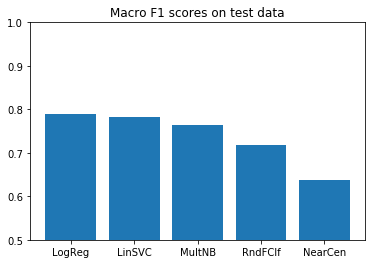

In [44]:
count = range(len(scores_sorted))
plt.ylim(0.5, 1)
plt.bar(count, list(scores_sorted.values()))
plt.xticks(count, list(scores_sorted.keys()))
plt.title(f"Macro F1 scores on test data")
plt.show()

At this point one sensible thing to do would be to take one or few models from the top of our list, perhaps make an ensemble model, and to finally tune it using larger datasample. But, since we still have deep-learning ahead of us, I'll do something much simpler but still interesting: Let's fit much more data to those exact same classifiers and see if they improve.  

---

## Fit more train data to the tuned classifiers.
The classifiers were tuned on a small number of records. Now we fit them anew to a bigger chunk of data.
It would of course be more desirable to do the grid-search on the bigger chunk to begin with. We are just imagining a scenario, where we've obtained more data after tuning, and we wish to refit the model without repeating the grid-search. On should bare in mind that in general the tuned parameters are functions of the volume of data, so this approach relies on the assumption that those functions are not varying very fast, and it probably makes sense only if the new chunk is not many orders of magnitude bigger.

In [22]:
models = load('arXiv_shallow_gridscv5_bestparams_on_160000.joblib')

file = os.path.join("data", "notex_all.csv")
big_data_train = pd.read_csv(file, delimiter='\t', nrows=big_number) 
big_data_test = pd.read_csv(file, delimiter='\t', nrows=(total-big_number), skiprows=big_number, header=None, names=['text', 'label'])

big_data_train.shape, big_data_test.shape

((700000, 2), (138804, 2))

In [24]:
big_text_train = big_data_train.text
big_y_train = label_e.transform(big_data_train.label)

big_text_test = big_data_test.text
big_y_test = label_e.transform(big_data_test.label)

In [28]:
# the scores obtained on the test sample are stored in a new dict and the refitted models are appended in the 'models' dict

big_test_ranking = {}

print(f"Fitting to {len(big_text_train)} records. Testing on unseen {len(big_text_test)}.")

for name, (model, original_grid, score, best_params_) in models.items():
    
    clf = build_clf(name, model)
    clf.set_params(**best_params_)
    tick = time.time()
    clf.fit(big_text_train, big_y_train)
    tock = time.time()
    
    big_test_ranking[name] = [f1_score(big_y_test, clf.predict(big_text_test), average='macro'), clf]
    
    print(f" {name} in {(tock - tick)/60:.0f} min.")

Fitting to 700000 records. Testing on unseen 138804.


C:\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


 LogReg in 45 min.
 LinSVC in 7 min.
 RndFClf in 29 min.
 NearCen in 4 min.
 MultNB in 3 min.


### Display macro F1 for all the classifiers - after refitting on bigger dataset.

In [29]:
# Sort the dict with final F1 scores
# Save the the winning classifier

ranking_list = sorted(big_test_ranking.items(), key=lambda item: item[1][0], reverse = True)

winner = ranking_list[0][0]
winner_clf = big_test_ranking[winner][1]

scores_sorted = {name: score for (name, [score, _]) in ranking_list}
scores_sorted

{'LinSVC': 0.802025130989597,
 'LogReg': 0.80040975529827,
 'MultNB': 0.782374150372291,
 'RndFClf': 0.684741838298042,
 'NearCen': 0.6340358101991361}

### Linear SVClassifier took the lead
Linear SVC and MultinomialNaiveBayes improved the most, by almost 2 %-points. LogisticRegression by about 1%-point. No change in the perfomance of NearestCentroidClassifier. And the Random Forest deteriorated by 3%-points.

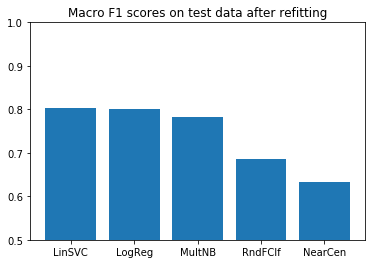

In [32]:
count = range(len(scores_sorted))
plt.ylim(0.5, 1)
plt.bar(count, list(scores_sorted.values()))
plt.xticks(count, list(scores_sorted.keys()))
plt.title("Macro F1 scores on test data after refitting")
plt.show()

In [33]:
predicted_big_y_test = winner_clf.predict(big_text_test)

In [34]:
print(classification_report(big_y_test, predicted_big_y_test, target_names=label_e.classes_))
conf_mtrx = confusion_matrix(big_y_test, predicted_big_y_test)
conf_mtrx

              precision    recall  f1-score   support

          cs       0.87      0.89      0.88     18336
        math       0.91      0.91      0.91     31597
        phys       0.98      0.96      0.97     83929
       q-bio       0.61      0.81      0.70      1796
       q-fin       0.70      0.84      0.76       765
        stat       0.51      0.70      0.59      2381

   micro avg       0.93      0.93      0.93    138804
   macro avg       0.76      0.85      0.80    138804
weighted avg       0.94      0.93      0.93    138804



array([[16302,   908,   275,   186,    54,   611],
       [ 1063, 28864,   789,   136,   101,   644],
       [  866,  1807, 80406,   527,    84,   239],
       [   92,    31,   135,  1460,     4,    74],
       [   36,    36,    12,     5,   642,    34],
       [  456,   120,    34,    74,    30,  1667]], dtype=int64)

### The *Statistics* class appears to be escpecially ambigous
Which is not that surprising seeing as many articles from other classes might also report in the abstract the statistical analysis employed in the study and the main findings in the language of statistics. At the same time, strictly statistical studies have little chance but to employ mathematics and computer science.

### See how the articles have flown between classes in the confusion matrix

In [35]:
rescaled_nofuss_conf_mtrx = nofuss_conf_mtrx * len(big_y_test)/len(y_test)
(conf_mtrx - rescaled_nofuss_conf_mtrx).sum() # 0

5.6559201766503975e-12

In [36]:
np.round(conf_mtrx - rescaled_nofuss_conf_mtrx, -1)

array([[ 320., -180., -130.,   20.,   10.,  130.],
       [-290.,  160., -190.,   10.,  -20.,  140.],
       [  20.,   20., -320.,  160.,   20.,   80.],
       [ -80.,  -20.,  -20.,  330.,    0.,  -20.],
       [ -40.,  -40.,  -20.,    0.,   20.,  -10.],
       [-140., -110.,  -20.,   30.,    0.,  170.]])

### All the rarer classes had gained ground, wheras the most common one, *physics*, was depleted. Encouraging.

---

## Store the best model in a file

In [37]:
winner_clf

Pipeline(memory=None,
     steps=[('delatex', DeLaTeX(behave='mask',
    pattern='(\\${1,2}[\\s\\w\\d\\\\,\\.=\\(\\)*{}/\\[\\]^;:\'`<>|%&@\\"!\\?~#+-]*?\\${1,2})',
    repl=' _LATEX_ ')), ('tfidf_v', TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.float64'>, encoding='utf-8', ...ax_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0))])

In [38]:
# joblib / pickle
dump(winner_clf, winner+f'_fit-to-{len(big_text_train)}.joblib') 

['LinSVC_fit-to-700000.joblib']

In [39]:
some_clf = load('LinSVC_fit-to-700000.joblib')
some_clf

Pipeline(memory=None,
     steps=[('delatex', DeLaTeX(behave='mask',
    pattern='(\\${1,2}[\\s\\w\\d\\\\,\\.=\\(\\)*{}/\\[\\]^;:\'`<>|%&@\\"!\\?~#+-]*?\\${1,2})',
    repl=' _LATEX_ ')), ('tfidf_v', TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.float64'>, encoding='utf-8', ...ax_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0))])

In [42]:
label_e.inverse_transform(some_clf.predict(random_abstracts))

array(['cs', 'phys', 'q-bio', 'cs', 'math', 'q-fin', 'stat'], dtype=object)

---
### End